# Credit Card Fraud Detection

## The Data   

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.   
Can be found here: https://www.kaggle.com/mlg-ulb/creditcardfraud

## The goal of the Project

For this project, we'll use everything we've learned about Data Science and Machine Learning thus far to source a dataset, preprocess and explore it, and then build and interpret a classification model that answers your chosen question.

Our goal is to predict if a transaction was fraudulent or not.

In [1]:
# basic libraries
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

# display options
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# date
from datetime import datetime 

# visualizations libraries
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# ML libraries
import itertools
from collections import Counter
from sklearn.datasets import make_classification
from numpy import where

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC # Support Vector Machine Classifier
from sklearn.metrics import precision_score, recall_score,confusion_matrix, classification_report, accuracy_score, f1_score  # Skearns Metrics
from sklearn.neighbors import KNeighborsClassifier # KNN Classifier
from xgboost import XGBClassifier # Boosting Algo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc # Comparing Various Classifiers

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [3]:
df = pd.read_csv('creditcard.csv')

## Preview the data

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

#### Check for NaN values

In [6]:
df.isna().any().any()

False

In [7]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

## Examine imbalance of the data

In [10]:
print('Raw counts: \n')
print(df['Class'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(df['Class'].value_counts(normalize=True))

Raw counts: 

0    284315
1       492
Name: Class, dtype: int64
-----------------------------------
Normalized counts: 

0    0.998273
1    0.001727
Name: Class, dtype: float64


It means we have a dataset with 1 to 1000 class distribution, meaning that we have 284 315 zeros to 492 ones, or 99.87 percent for class 0 and about 0.12 percent for class 1.

### Visualizing our data

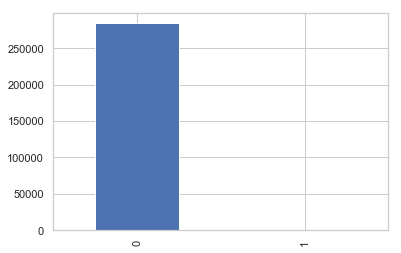

In [11]:
df['Class'].value_counts().plot.bar()

In [12]:
# define target and features
y = df['Class']
X = df.drop(columns=['Class'], axis=1)

X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=3)

Counter({0: 990, 1: 10})


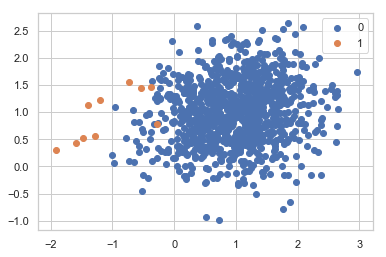

In [13]:
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

For a better understanding of our data let's have a better look at our fraud and non fraud transactions:

In [14]:
print ("Fraud")
print (df.Amount[df.Class == 1].describe())
print ()
print ("Normal")
print (df.Amount[df.Class == 0].describe())

Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


It looks like in average the amount fraud transactians was higher than the non fraudulent transactions

In [15]:
# df.hist(figsize=(20,20))
# plt.show()

### Transactions in time

In [16]:
fraud = df[df['Class']==1]['Time']
non_fraud = df[df['Class']==0]['Time']

hist_df = [fraud, non_fraud]
group_labels = ['Fraud', 'Not Fraud']

fig = ff.create_distplot(hist_df, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions by Time', xaxis=dict(title='Time[s]'))
iplot(fig, filename='dist_only')

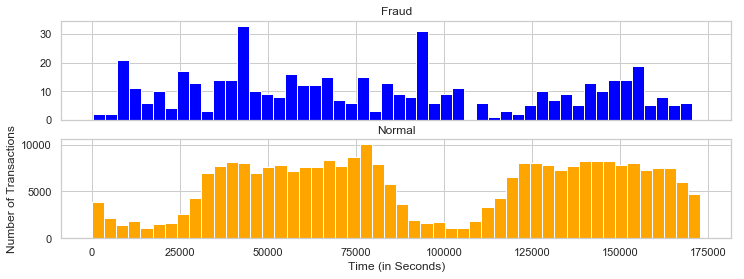

In [17]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(df.Time[df.Class == 1], bins = bins, color='blue')
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins, color='orange')
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

### Split to train and test sets (not normalised data)

In [18]:
y = df['Class']
X = df.drop(columns=['Class'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [19]:
# Training set
print(y_train.value_counts())
print('\n')
# Test set
print(y_test.value_counts())

0    213260
1       345
Name: Class, dtype: int64


0    71055
1      147
Name: Class, dtype: int64


## Create a baseline (non normalised data)

For a baseline model do a Logistic Regression model

In [21]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
y_pred = logreg.predict(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)
# sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))
print(f'Presison: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'f1_score: {f1_score(y_test, y_pred)}')

AUC: 0.9008656224434748
Presison: 0.6029411764705882
Recall: 0.5578231292517006
f1_score: 0.5795053003533569


## Scaling

As the data description says, all our features have been PCA transformed except 'Time' and 'Amount'. So we are scaling only these two columns:

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
scaler = StandardScaler()
df.Amount = scaler.fit_transform((df.Amount).values.reshape(-1,1))
df.Time = scaler.fit_transform((df.Time).values.reshape(-1,1))

In [24]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


## Splitting to Train and Test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

## KNN

In [ ]:
# Convert into a DataFrame
# scaled_df_train = pd.DataFrame(scaled_data_train)
# scaled_df_train.head()

In [26]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier(n_jobs=-1)

# Fit the classifier
clf.fit(X_train, y_train)

# # Predict on the test set
test_preds = clf.predict(X_test)

In [27]:
# Complete the function
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, test_preds)

Precision Score: 1.0
Recall Score: 0.034013605442176874
Accuracy Score: 0.9980056739979214
F1 Score: 0.06578947368421054


We got a super high Accuracy Score (99,9%) and very low Recall Score

Try a more detailed approach to KNN:

In [32]:
def acc(y_test,prediction):
    # Printing Accuracy
    cm = confusion_matrix(y_test, prediction)
    recall = np.diag(cm) / np.sum(cm, axis = 1)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    
    print ('Recall:', recall)
    print ('Precision:', precision)
    print ('\n clasification report:\n', classification_report(y_test,prediction))
    print ('\n confussion matrix:\n',confusion_matrix(y_test, prediction))
    print("\n Accuracy Percentage  is : {}%".format(accuracy_score(y_test,prediction) * 100))
    ax = sns.heatmap([precision,recall],linewidths= 0.5,cmap="YlGnBu")

In [33]:
y_pred = clf.predict(X_test)
acc(y_test,y_pred);

In [34]:
def train(clf,X,Y,x,y):
    clf.fit(X,Y)
    y_pred = clf.predict(x)
    acc(y_pred,y)
    return y_pred

Recall: [0.99800553 1.        ]
Precision: [1.         0.03401361]

 clasification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71197
          1       0.03      1.00      0.07         5

avg / total       1.00      1.00      1.00     71202


 confussion matrix:
 [[71055   142]
 [    0     5]]

 Accuracy Percentage  is : 99.80056739979214%


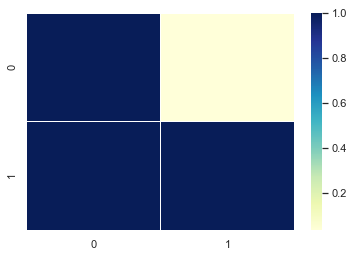

In [35]:
knn = KNeighborsClassifier()
knn_pred = train(knn,X_train,y_train,X_test,y_test)

### XGBoost

In [28]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Training Accuracy: 99.97%
Validation accuracy: 99.94%


In [ ]:
# xgb = XGBClassifier()
# xgb.fit(X_train, y_train)

# training_preds = xgb.predict(X_train)
# test_preds = xgb.predict(X_test)

# training_accuracy = accuracy_score(y_train, training_preds)
# test_accuracy = accuracy_score(y_test, test_preds)

# print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [36]:
xgb = XGBClassifier(max_depth= 9,
                           learning_rate=0.001,
                           n_estimators=5000,
                           objective='binary:logistic',
                           gamma=0,
                           seed=1)
train(xgb,X_train,y_train,X_test,y_test)

KeyboardInterrupt: 

### Random Forest Classifier

In [ ]:
rndmfor = RandomForestClassifier(n_estimators=1000, max_depth=13,random_state=0)
rndmfor_pred = train(rndmfor,X_train,y_train,X_test,y_test)

## SMOTE

I'm going to use the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.   
I'm being too careful, so I'll import the csv and do the scaling (maybe not needed at all do it 2x)

In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
y = df['Class']
X = df.drop(columns=['Class'], axis=1)

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

In [ ]:
# Previous original class distribution
print(y_train.value_counts()) 

# Fit SMOTE to training data
X_train, y_train = sm.fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_smote).value_counts()) 

In [ ]:
# observe that data has been balanced
pd.Series(y_train_smote).value_counts().plot.bar()